# Forecasting

Forecasting is ubiquitous across industries in order to determine expected future demand based on current demand. In this post, I'll summarize and implement several of the most common methods for forecasting and compare the accuracy of their results. The methods covered will include Facebook's Prophet library, Holt-Winters models, ARIMA, and neural networks. 

The data that will be forecasted include $\mathrm{CO_2}$ levels as measured by the [Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/ccgg/trends/) in Hawaii as well as bike share usage data collected from Columbus' [COGO](https://www.cogobikeshare.com/system-data) bike share. Both exhibit clear seasonality but offer different sampling rates. The $\mathrm{CO_2}$ data is sampled in monthly intervals whereas COGO gives data for each individual trip allowing for resampling over shorter durations. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# 1. Data

The $\mathrm{CO_2}$ levels data extends from 1958-2018. It is sampld in monthly intervals and exhibits regular yearly seasonality. 

Whereas the COGO bikeshare usage extends from roughly 2014-2018 and has been resampled into daily intervals. It exhibits yearly and weekly cycles. Dockless bikeshare and escooters did not come to Columbus until after this data set was completed so their influence on COGO usage is not reflected in this data. The data was resampled into daily increments because a finer resampling (i.e. hourly intervals) would have left many intervals with no bike usage at all which would have made forecasting more difficult.

In [2]:
co2 = pd.read_csv('Data/Mauna Loa Monthly Co2.csv', parse_dates=True, index_col='Month')['Interpolated']
cogo_daily = pd.read_csv('Data/COGO Daily.csv', parse_dates=True, index_col='Date', squeeze=True)

co2 = co2.asfreq('MS')
cogo_daily = cogo_daily.asfreq('D')

## 1.1 Plot Data

Cycles in the data can be seen in plots of the data.

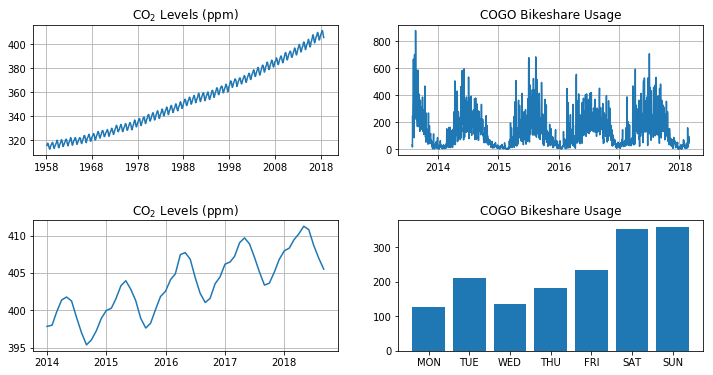

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(co2)
plt.title('CO$_2$ Levels (ppm)')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(co2['2014':])
plt.title('CO$_2$ Levels (ppm)')
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(cogo_daily)
plt.title('COGO Bikeshare Usage')
plt.grid(True)

plt.subplot(2,2,4)
s = pd.Timestamp('2017-6-5')
f = s + pd.Timedelta('6 days')
wd = cogo_daily[s:f].index.map(pd.Timestamp.weekday)
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
              4:'FRI', 5:'SAT', 6:'SUN'}
ticks = [weekday_map[d] for d in wd.tolist()]
x_pos = np.arange(len(ticks))
plt.bar(x_pos, cogo_daily[s:f])
plt.xticks(x_pos, ticks)
plt.title('COGO Bikeshare Usage')

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

## 1.2 Power Spectrum

One method to check for seasonality other than by plotting the data is to check the power spectrum. The power spectrum uses Fourier analysis in order to isolate the frequencies that most affect the data.

Unlike a traditional power spectrum, the x-axis is based on the period rather than the frequency.

In [4]:
def plot_ps(ts):
    """Plots power spectrum of time series. X-axis is over period rather than frequency.
    
    Args:
        ts (Series): time series
    """
    ps_y = np.abs(np.fft.rfft(ts.values))**2
    ps_x = np.fft.rfftfreq(ts.size, d=1)
    plt.plot(1/ps_x[1:], ps_y[1:])
    plt.xlabel('Period ({})'.format(ts.index.inferred_freq))

### 1.2.1. $\mathrm{CO_2}$ Power Spectrum

For the $\mathrm{CO_2}$ data, there are spikes at 6 and 12 months indicative of yearly cyclic behavior. The background increase in the power spectrum is the result of the linearity of the data.

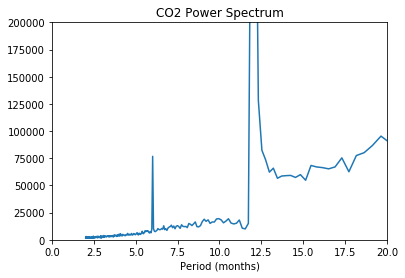

In [5]:
plot_ps(co2)
plt.xlim([0, 20])
plt.ylim([0, 200000])
plt.title('CO2 Power Spectrum')
plt.xlabel('Period (months)')
plt.show()

### 1.2.1. COGO Power Spectrum

Whereas the COGO data has weekly and yearly seasonality. The yearly data is less precise because there is not many years of data.

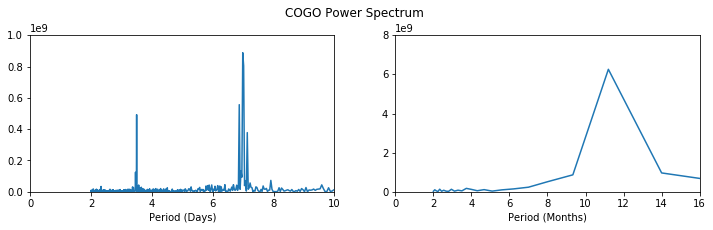

In [6]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('COGO Power Spectrum')
fig.subplots_adjust(top=0.85)

plt.subplot(1,2,1)
plot_ps(cogo_daily)
plt.xlim([0, 10])
plt.ylim([0, 1E9])
plt.xlabel('Period (Days)')

plt.subplot(1,2,2)
cogo_monthly = cogo_daily.resample('MS').sum()
plot_ps(cogo_monthly)
plt.xlim([0, 16])
plt.ylim([0, 8E9])
plt.xlabel('Period (Months)')

# plt.subplots_adjust(hspace=0.8, wspace=0.2)
plt.show()

## 1.3 Testing

In order to compare forecasts between different methods, the data sets will be split into train and test sets and the mean-squared-error will be calculated on the testing data. While cross-validation could be used here, I'm simply using the last third of the data as the test set. 

In [7]:
from sklearn.metrics import mean_squared_error

def train_test_split(ts, p):
    """Divides time series into train and test segments
    
    Args:
        ts (Series): time series
        p (float): the fraction of length of the time series at which to split
    Returns:
        splitting (tuple): Tuples containing train and test segments
    """
    
    train_size = int(len(ts) * p)
    test_size = len(ts) - train_size
    return((ts[0:train_size], ts[train_size:len(ts)]))

# Accumuulates MSE for each forecasting method 
co2_mse = pd.DataFrame(columns=['Test MSE'])
cogo_mse = pd.DataFrame(columns=['Test MSE'])

# Divide data sets into test and train sets
co2_train, co2_test = train_test_split(co2, 0.67)
cogo_daily_train, cogo_daily_test = train_test_split(cogo_daily, 0.67)

# 2. Prophet

Facebook's [Prophet library](https://facebook.github.io/prophet/) came out in 2017 and provides a simple method of modeling and forecasting. The library models the trend as a piecewise linear function and the seasonal components with partial Fourier sums. The method is resistent to missing data and the library is automatically tuned to detect multiple levels of seasonality (daily, weekly, yearly).

I like the Prophet library for its simplicity. Fourier series and piecewise linear functions are relatively intutive. Plus, the components are purely additive making it easy to understand or extend.

## 2.1 $\mathrm{CO_2}$ Data with Prophet

The $\mathrm{CO_2}$ data extends over 60 years and the forecast will try to predict the last 20 years. For most industries, a 20 year forecast is an overly long time frame, but it is appropriate for the time scales involved with climate change. However, this long forecast period will amplify even small deviations in the forecasting method.

The Prophet library models the trend as a piecewise linear function and projects into the future from that final piece. While the slope is mostly constant, it does slowly vary over time. The varying slope combined with the long forecast period causes the forecast to be highly dependent on that final slope. I'm using the final 10% (4 years) of the training data to calculate that slop rather than the default 20% (8 years) so that the forecast would better capture any final changes. Nevertheless, the forecast undershoots over the test data. An alternative model may try to include how the slope changes over time. 

Whereas, the yearly seasonality appears incredibly consistent over the entire time set and appears very well modeled by the partial Fourier sum used by the Prophet library.

The forecasted and test data are compared below. The components of the Prophet modelled are also decomposed into their individual parts.

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train MSE: 0.11
Test MSE: 7.14


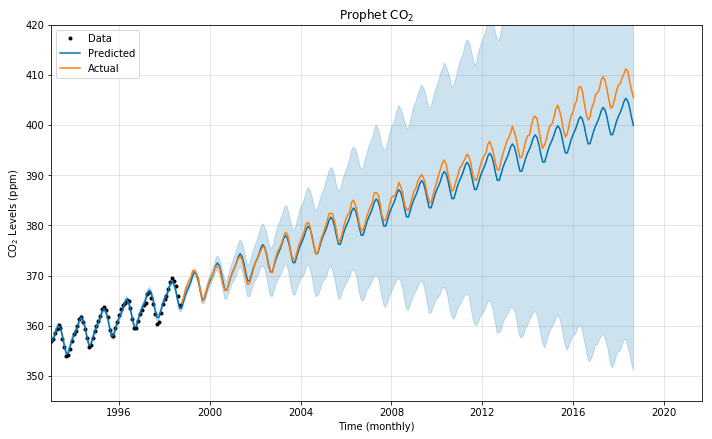

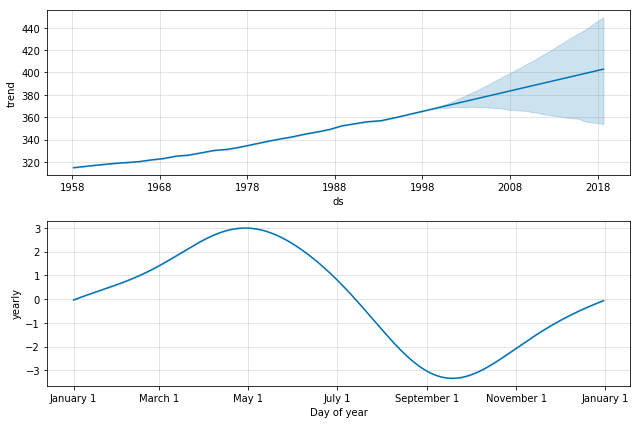

In [8]:
from fbprophet import Prophet

train = co2_train
test = co2_test

df = pd.DataFrame()
df['ds'] = train.index
df['y'] = train.values

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = Prophet(interval_width=0.95, yearly_seasonality=4, changepoint_range=0.9)
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test), freq=test.index.freqstr)
    res = model.predict(future)

y_pred = res[['ds', 'yhat']].set_index('ds')
train_pred = y_pred.head(len(train))
test_pred = y_pred.tail(len(test))

train_mse = mean_squared_error(train, train_pred)
test_mse = mean_squared_error(test, test_pred)

co2_mse.loc['Prophet'] = test_mse

print('Train MSE: {:.2f}'.format(train_mse))
print('Test MSE: {:.2f}'.format(test_mse))

cmap = plt.get_cmap("tab10")
model.plot(res, xlabel='Time (monthly)', ylabel='CO$_2$ Levels (ppm)')
plt.plot(test, color=cmap(1))
plt.title('Prophet CO$_2$')
plt.xlim(xmin=pd.Timestamp('1993'))
plt.ylim([345, 420])
plt.legend(['Data', 'Predicted', 'Actual'])
plt.show()

model.plot_components(res)
plt.show()

## 2.2 COGO Data with Prophet

The COGO data has a greater variance than the $\mathrm{CO_2}$ data and it would be unreasonable to expect a model to be able to predict human behavior as well as the $\mathrm{CO_2}$ data. Nevertheless, the data exhibits an astonishingly regular periodicity both yearly and weekly and the Prophet library is easily able to capture that. Whereas, the overall trend is mostly flat after the small decrease after the first year.

The fit as well as the component parts for the model are shown below.

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train MSE: 6378.16
Test MSE: 5898.78


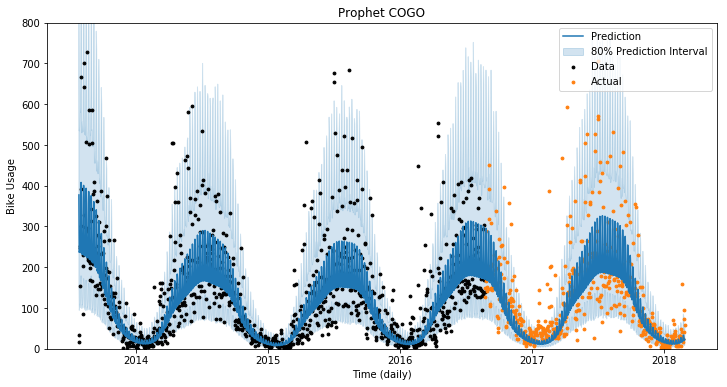

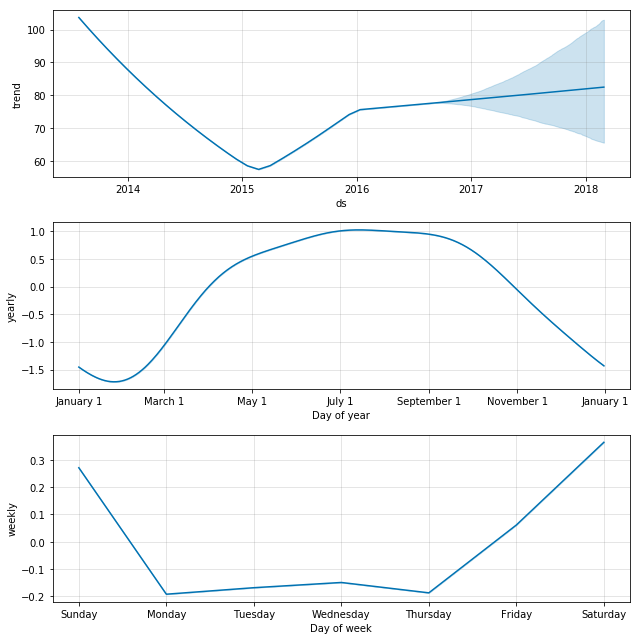

In [9]:
train = cogo_daily_train
test = cogo_daily_test

df = pd.DataFrame()
df['ds'] = train.index
df['y'] = np.log(train.values+1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = Prophet(interval_width=0.8, yearly_seasonality=4)
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test), freq=test.index.freqstr)
    res = model.predict(future)

res = (np.exp(res.set_index('ds'))-1)
y_pred = res[['yhat']]
train_pred = y_pred.head(len(train))
test_pred = y_pred.tail(len(test))

train_mse = mean_squared_error(train, train_pred)
test_mse = mean_squared_error(test, test_pred)

cogo_mse.loc['Prophet'] = test_mse

print('Train MSE: {:.2f}'.format(train_mse))
print('Test MSE: {:.2f}'.format(test_mse))

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(12,6))
plt.fill_between(res.index,  res['yhat_lower'], res['yhat_upper'], color=cmap(0), alpha=0.2, label='80% Prediction Interval')
plt.plot(res.index, res['yhat'], color=cmap(0), label='Prediction')
plt.scatter(train.index, train.values, color='black', s=8, label='Data')
plt.scatter(test.index, test.values, color=cmap(1), s = 8, label='Actual')
plt.legend()
plt.title('Prophet COGO')
plt.xlabel('Time (daily)')
plt.ylabel('Bike Usage')
plt.ylim([0, 800])
plt.show()

model.plot_components(res.reset_index())
plt.show()

# 3. Exponential Smoothing

Exponential Smoothing methods are the second type of model tested. Exponential smoothing relies on predicting values using an iteratively smaller percentage of previous values.

### Exponential Smoothing: $\hat{y}_t = \alpha y_{t-1} + (1-\alpha) \hat{y}_{t-1}$

However, complex models like Holt-Winters or ETS (Error, Trend, Seasonality) don't just use exponential smoothing for the level (average) but for the trend (slope) and seasonal components. 

## Holt-Winters

### Level: $l_t = \alpha (y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$

### Trend: $b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}$

### Seasonal: $s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma) s_{t-m}$

Forecasts are then predicted by using

### $y_{t+h} = l_t + h b_t + s_{t+h}$.

The benefits of these models are that they allow each of each component to slowly change over time. For example, unlike the Prophet model, the slope is no longer assumed to be constant. And unlike Fourier decomposition, they can take into account seasonalities whose periods change over time.

The disadvantages of this technique are that they are iterative and don't handle missing data as well. The Python implementation also only allows for a single seasonal period so the COGO dataset required a few workarounds. Simply using a 365 day seasonality caused issues with the COGO dataset because after a year the day of the week had changed.

Overall, these models have been relatively fast to train and have yielded decent results.

## 3.1 $\mathrm{CO_2}$ Data with Exponential Smoothing

The $\mathrm{CO_2}$ seasonality is correctly modelled, but slight errors in the slope become more apparent over longer forecasting periods.

Test MSE: 14.92


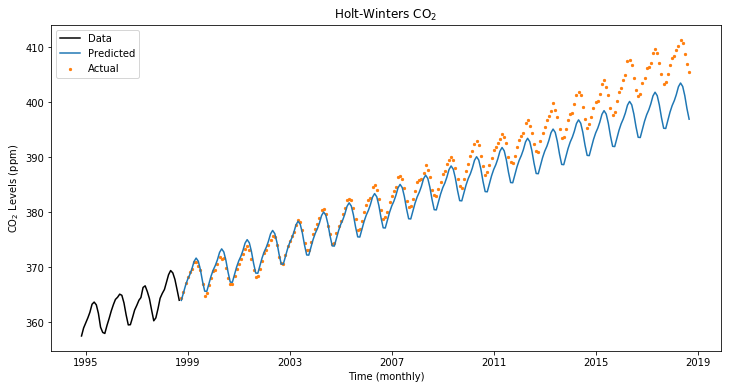

In [10]:
from statsmodels.tsa import holtwinters

train = co2_train
test = co2_test

model = holtwinters.ExponentialSmoothing(train, trend = 'add', seasonal='mul', seasonal_periods=12)
res = model.fit()
test_pred = res.predict(start=test.index[0], end=test.index[-1])

# MSE
test_mse = mean_squared_error(test, test_pred)
co2_mse.loc['Exponential Smoothing'] = test_mse
print('Test MSE: {:.2f}'.format(test_mse))

# Plot
s = test.index[1] - pd.DateOffset(years=4)
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(12,6))
plt.plot(train[s:], label='Data', color='black')
plt.plot(test_pred, label='Predicted', color=cmap(0))
plt.scatter(test.index, test.values, label='Actual', color=cmap(1), s = 5)
plt.legend()
plt.title('Holt-Winters CO$_2$')
plt.xlabel('Time (monthly)')
plt.ylabel('CO$_2$ Levels (ppm)')
plt.show()

## 3.2 COGO Data with Exponential Smoothing

The built-in exponential smoothing function is only able to include one seasonality period. In these situations, [Hyndman](https://otexts.org/fpp2/dhr.html) suggests addomg a partial Fourier series to model the longer seasonality. 

Several function were written to fit a partial Fourier sum to the data. Unlike with the power spectrum, the period of the Fourier components is based on the seasonality but also includes several higher harmonics.

In [11]:
from scipy.optimize import curve_fit

def fit_fourier_order(ts, order, P):
    """Returns function for partial fourier sum fit to the data
    
    Args:
        ts (Series): Time Series
        order (int): Number of harmonics to include
        P (int): Seasonality period
    Returns:
        fourier: Returns fitted function that takes an index and returns the fourier sum for that index
    """
    
    y = ts
    X = np.arange(len(ts))
    
    def fourier(x, *a):
        """Partial Fourier sums.
        
        Args:
            x (list(int)): Index for time interval
            a (list): List of parameters. First is constant. 
                      After that, alternates between cos and sin coefficients for each order"""
        ret = a[0] + a[1] * np.cos(2 * np.pi / P * x) + a[2] * np.sin(2 * np.pi / P * x)
        for deg in range(3, len(a), 2):
            ret += a[deg] * np.cos(2 * np.pi * ((deg+1)/2) / P * x) 
            + a[deg] * np.sin(2 * np.pi * ((deg+1)/2) / P * x)
        return ret

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(fourier, X, y, [0] + [1.0, 1.0] * order)
        
    def fourier_wrapper(x):
        """Wraps fourier and includes the fitted parameters"""
        return(fourier(x, *popt))
    
    return(fourier_wrapper)

Because both the value and the variance vary seasonally, I include the Fourier series multiplicatively. I transform the data by dividing it by a yearly partial Fourier sum before modelling it using exponential smoothing. After the prediction step, I reverse the transformation. 

Test MSE: 6198.83


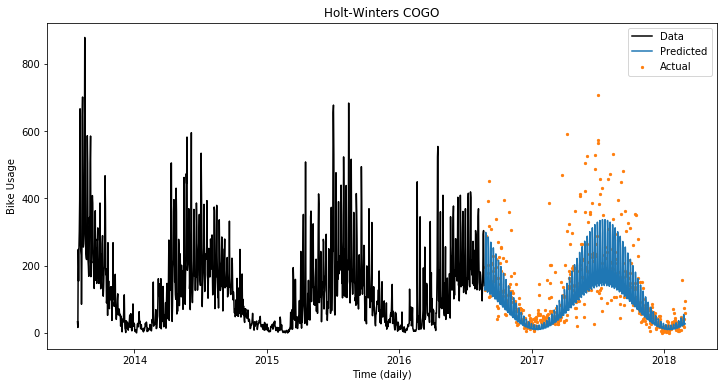

In [12]:
from statsmodels.tsa import holtwinters

train = cogo_daily_train 
test = cogo_daily_test

fourier_series = fit_fourier_order(train, 2, 365)
x = np.arange(len(train))
fourier_train = fourier_series(x)

model = holtwinters.ExponentialSmoothing(train / fourier_train, trend = None, seasonal='add', seasonal_periods=7)
res = model.fit()

x = np.arange(len(train), len(train)+len(test))
fourier_test = fourier_series(x)
test_pred = res.predict(start=test.index[0], end=test.index[-1])
test_pred = test_pred * fourier_test

# MSE
test_mse = mean_squared_error(test, test_pred)
cogo_mse.loc['Exponential Smoothing'] = test_mse
print('Test MSE: {:.2f}'.format(test_mse))

# Plot
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(12,6))
plt.plot(train, label='Data', color='black')
plt.plot(test_pred, label='Predicted', color=cmap(0))
plt.scatter(test.index, test.values, label='Actual', color=cmap(1), s = 5)
plt.legend()
plt.title('Holt-Winters COGO')
plt.xlabel('Time (daily)')
plt.ylabel('Bike Usage')
plt.show()

# 4. ARIMA

Of the forecasting methods, ARIMA models are perhaps the most complciated. ARIMA stands for autoregressive integrated moving average and includes those thress components.

## Autoregressive (AR)

Autoregressive models forecast the next time step by creating a linear differenced equation (the discrete analog to a linear differential equation) of the last several time points. 

### $y_t = a y_{t-1} + b y_{t-2} + c$

AR models are typically used to model stationary data. 

Solutions to these equations are similar to their ODE analogs. For example, the steady state 2nd order differential equations have solutions that include exponential decays and damped harmonic oscillators.

## Integrated (I)

Many data sets are not stationary. However, taking the difference between adjacent points often causes the data to become stationary. Then the differenced data is modeled with an AR model.

### $y_t' = a y_{t-1}' + b y_{t-2}' + c$

We can think of these cases as modeling the slope with a difference equation (exponential decay or damped harmonic oscillator). 

Mathematically though, each difference step is equivalent (within constants) to increasing the order of the AR by one.

## Moving Average (MA)

The moving average component is not related to exponential moving averages. Rather, it refers to how many time steps random noise or perturbations effect the data.

### $y_t = \theta_{t-1} \epsilon_{t-1} + \theta_{t-2} \epsilon_{t-2} + c$

The following section will create a lot of helper functions to help create these models. They'll be explained more when they're used.

In [13]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa as tsa
import scipy.stats as stats
import warnings
import itertools
import sys
   
def ndiffs(x, test='kpss', reg='c', alpha=0.05, max_d=2):
    """Tests the number of diffs necessary for stationarity
    
    Args:
        x (Series): time series
        test (str{'kpss', 'adf'}): Method for testing stationarity
        reg (str{'c', 'ct'}): Indicates whether data is stationary around a constant ('c') or trend ('ct')
        alpha (float): Significance level for test
        max_d (int): Maximum diffs to check
        
    Returns:
        ndiffs (int): Number of diffs required for stationarity or -1 if stationarity is never reached
    """
    for i in np.arange(max_d+1):
        s = np.diff(x, i)
        if test == 'kpss':
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                (_, p_value, _, _) = tsa.stattools.kpss(s, regression=reg)
            if p_value > alpha:
                return(i)
        elif test == 'adf':
            (_, p_value, _, _, _, _) = tsa.stattools.adfuller(s, regression=reg)
            if p_value <= alpha:
                return(i)    
    return(-1)

def nsdiffs(x):
    """Tests to determine whether seasonal differencing is necessary. 
    
    Args:
        x (Series): time series
        
    Returns:
        nsdiffs (bool): Returns 1 if there is strong seasonal component to the series and 0 if there isn't.
    """
    result = tsa.seasonal.seasonal_decompose(x, model='additive')
    Fs = max(0, 1 - np.var(result.resid)/np.var(result.resid + result.seasonal))
    return(1 if (Fs > 0.64) else 0)

def grid_search_model(ts, params):
    """Determines the SARIMAX model that fits the time series the best. Performs a grid search over the inputed parameters.
    
    Args:
        ts (Series): Time Series
        params (list{'order' : i, 'seasonal_order' : j}): List of parameters to test with SARIMAX
    Returns:
        best_model: Returns model that fits the time series the best
    
    """
    best_aic = np.inf
    best_model = None
    for p in params:
        with warnings.catch_warnings():
#             warnings.filterwarnings('error')
            warnings.simplefilter("ignore")
            try:
                tmp_model = sm.tsa.statespace.SARIMAX(ts, **p)

                res = tmp_model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = tmp_model
            except ValueError:
#                 print(sys.exc_info()[0])
                continue
    return(best_model)

def ts_plot(ts, lags=None, title='Time series'):
    '''Calculates acf, pacf, histogram, and qq plot for a given time series
    
     Args:
        ts (Series): Time series
        lags (int): Number of lags to include
        title (str): Title of plot
    '''
    # if time series is not a Series object, make it so
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    
    # initialize figure and axes
    fig = plt.figure(figsize=(10, 8))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    acf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    ts.plot(ax=ts_ax)
    ts_ax.set_title(title)
    
    # acf and pacf
    smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax, alpha=0.05, zero=False) 
    smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax, alpha=0.05, zero=False)
    
    # qq plot
    sm.qqplot(ts, line='s', ax=qq_ax)
    qq_ax.set_title('Normal QQ Plot')
    
    # hist plot
    hist_ax.set_title('Histogram')
    (_, bins, _) = hist_ax.hist(ts, bins=35)
    bin_width = bins[1] - bins[0]

    m, sd = stats.norm.fit(ts)
    x = np.linspace(min(ts), max(ts), 50)
    y = stats.norm.pdf(x, loc=m, scale=sd)*bin_width*ts.size
    hist_ax.plot(x, y)

    plt.tight_layout()
    plt.show()
    
    (acf, qstat, pvalues) = smt.stattools.acf(ts, nlags=10, qstat=True)
    print('Independent Residuals (Ljung-Box Test)? {}'.format(pvalues[-1] > 0.05))

## 4.1 $\mathrm{CO_2}$ Data with ARIMA

### Stationarity 

ARIMA tests require the time series to be stationary or at least able to become stationary via differencing. While you to check for stationarity by eye, I have two functions `ndiffs` and `nsdiffs` meant to test for stationarity (similar to the R Forecast package). `ndiffs` returns the number of times differencing is necessary to make the time series stationary by using either the KPSS or the Augmented Dickey-Fullter (ADF) test to check for stationarity. The KPSS test has a null hypothesis of stationarity or no unit root; whereas the ADF test has a null hypothesis that there is a unit root. These tests only look for the specific case of non-stationary because of a unit root and are not all-encompassing. Solutions with a unit root are not exponentially explosive nor mean-reverting. Shocks to the series yield a permanent impact on the mean. `nsdiffs` meanwhile only checks to see whether there is a significant seasonality component.

There are multiple ways of making a time series stationary. The common methods listed below involve taking the difference. 

**Difference Stationary** - Taking the difference between adjacent points is a common way to create a stationary series.

**Seasonal Stationary** - For seasonal data, the differences may need to be taken across the seasonal gaps to create a stationary series.

**Variance Stationary** - If the mean is stationary but the variance is changing, taking the log of the time series can stabilize the variance.

In [14]:
train = co2_train
test = co2_test 

print('ndiffs:', ndiffs(train))
print('nsdiffs:', nsdiffs(train))

ndiffs: 1
nsdiffs: 1


From our tests, we see that for stationarity we need one difference and one seasonal difference. The plot below shows what that looks like and it appears to indeed be stationary.

To determine the order of the AR and MA components, we can check the partial autocorrelation function (PACF) and autocorrelation function (ACF). Sharp peaks in the PACF (and a gradual decline in the ACF) represent how large the order should be for the AR, and sharp peaks in the ACF (and a gradual decline in the PACF) help determine the order for the MA components.

In this case, we see sharp peaks in the ACF at 1 and 12 whereas the PACF appear to have more gradual declines. This suggests we should have at least one component in the MA for both the seasonal and non-seasonal components. While looking at these charts can help diagnose what would be a reasonable fit, ultimately we can leave it up to the computer to decide which model fits best.

The plotting function also does the Ljung-Box test on the time series. This test looks at the autocorrelation function and checks whether the data is distributed like white noise. The fact that our data fails the test indicates that there is extra data in the time series that can be used in the forecast. That's good becasue we haven't even modeled this data yet.

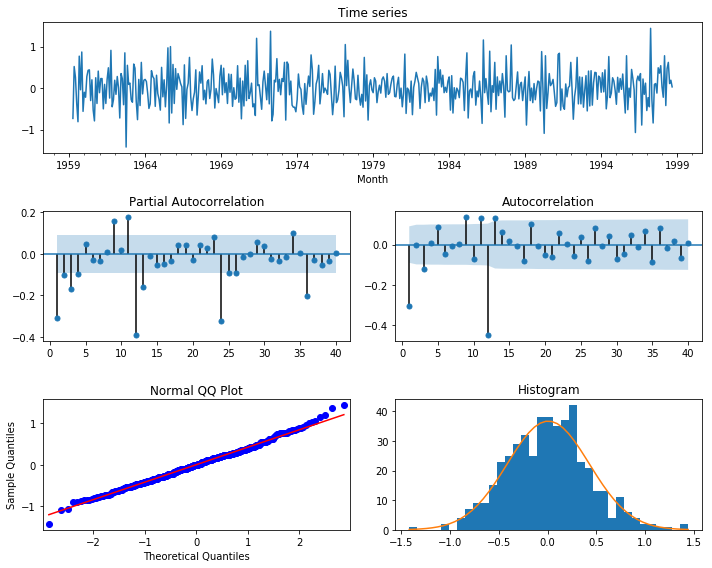

Independent Residuals (Ljung-Box Test)? False


In [15]:
ts_plot(train.diff(12).diff().dropna(), lags=40)

In order to determine the appropriate order for the AR and MA components, a grid search of various models are fitted to the data and tested.

In [16]:
p = q = range(0, 2)
d = [1]
pdq = list(itertools.product(p, d, q))
p = q = range(0, 2)
d = [1]
PDQ = list(itertools.product(p, d, q, [12]))
params = [{'order' : i, 'seasonal_order' : j} for i in pdq for j in PDQ]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = grid_search_model(train, params)
    res = model.fit()

Now that we've fit the data to our model, we can plot the residuals. The Ljung-Box test is passed and we can see from the histogram and ACF that the residuals remaining are mostly just random noise.

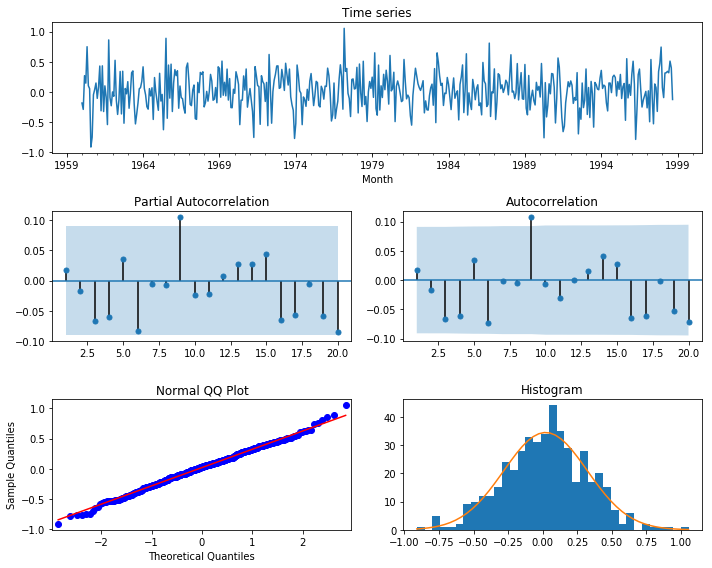

Independent Residuals (Ljung-Box Test)? True


In [17]:
ts_plot(res.resid['1960':], lags=20)

Now that the model has been fit, we can use it to predict future values. The end result isn't very different from what we've seen from the Holt-Winter or Prophet models. 

Test MSE: 11.69


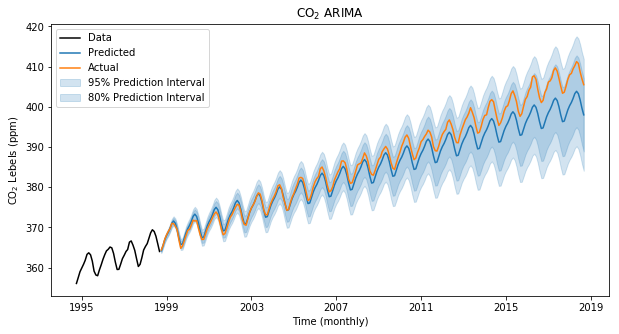

In [18]:
pred = res.get_prediction(start=test.index[0], end=test.index[-1])
test_mse = mean_squared_error(test, pred.predicted_mean)
co2_mse.loc['ARIMA'] = test_mse
print('Test MSE: {:.2f}'.format(test_mse))

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")

s = test.index[0]- pd.DateOffset(years=4)
plt.plot(train[s:], label='Data', color='black')
plt.plot(pred.predicted_mean, label='Predicted', color=cmap(0))
plt.plot(test, label='Actual', color=cmap(1))

pred_ci = pred.conf_int(alpha=0.05)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], 
                 color=cmap(0), alpha=0.2, label='95% Prediction Interval')

pred_ci = pred.conf_int(alpha=0.2)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], 
                 color=cmap(0), alpha=0.2, label='80% Prediction Interval')
plt.legend(loc='upper left')
plt.title('CO$_2$ ARIMA')
plt.xlabel('Time (monthly)')
plt.ylabel('CO$_2$ Lebels (ppm)')
plt.show()

## 4.2 COGO Data with ARIMA

The build-in ARIMA model only allows for one seasonal period. Plus, the ARIMA model doesn't work well for long seasonal periods. If the seasonal period is set to 365, then it needs to fit to 365 initial values which is a very slow process. Instead, I'll use the same transformation I used for the Holt-Winters model. I'll fit the yearly data with a partial fourier sum and then divide the time series by that sum. The result will then be modeled with ARIMA.

I also transform the data by taking the log of the data. This will ensure that my results are purely non-negative.

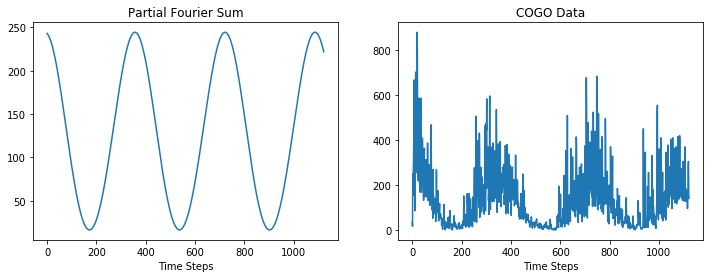

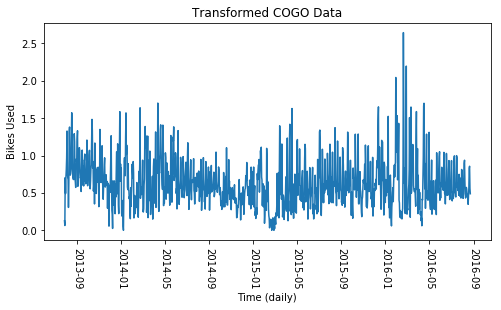

In [19]:
train = cogo_daily_train
test = cogo_daily_test

def transform(x):
    """Transform data to ensure fit is non-negative
    
     Args:
        x (Series): Time series
    """
    return(np.log(x+1))

def untransform(x):
    """Transform time series back 
    
     Args:
        x (Series): Time series
    """
    return(np.exp(x)-1)

fourier_series = fit_fourier_order(train, 2, 365)
transformed_train = transform(train / fourier_train)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x = np.arange(len(train))
fourier_train = fourier_series(x)
plt.plot(fourier_train)
plt.xlabel('Time Steps')
plt.title('Partial Fourier Sum')

plt.subplot(1,2,2)
plt.plot(train.values)
plt.xlabel('Time Steps')
plt.title('COGO Data')

plt.figure(figsize=(8,4))
plt.plot(transformed_train)
plt.xticks(rotation=-90)
plt.xlabel('Time (daily)')
plt.ylabel('Bikes Used')
plt.title('Transformed COGO Data')
plt.show()

After the transformation, my automated programs don't detect that any differences are necessary. However, there is still a weekly seasonality that I'll take into account.

In [20]:
print('ndiffs:', ndiffs(transformed_train))
print('nsdiffs:', nsdiffs(transformed_train))

ndiffs: 1
nsdiffs: 0


The order for a seasonal ARIMA model is often written as ARIMA(p,d,q)(P,D,Q)$_m$ where $p$ is the AR order, $d$ is the number of differences steps, and $q$ is the MA order. $P$, $D$, and $Q$ refer to the same components for the seasonal component with $m$ period seasonality. 

Based on the ACF and PACF, it appears the data could be modeled with a ARIMA(1, 0, 0)(2, 1, 0)$_7$ model, but the best model isn't always clear.

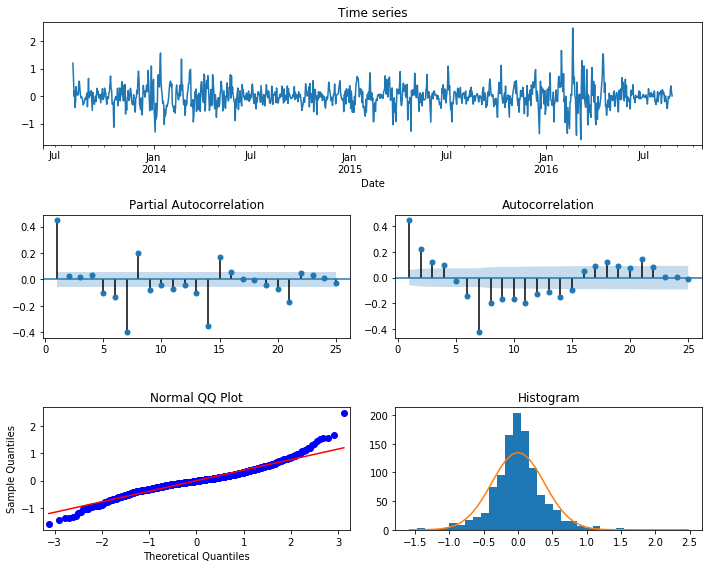

Independent Residuals (Ljung-Box Test)? False


In [21]:
ts_plot(transformed_train.diff(7).dropna(), lags=25)

To find the best model, we do a grid search around where we expect the model to be and find that a ARIMA(1,0,0,)(1,1,2)$_7$ model fits best.

In [22]:
p = q = range(0, 2)
d = [0]
pdq = list(itertools.product(p, d, q))
p = q = range(1, 3)
d = [1]
PDQ = list(itertools.product(p, d, q, [7]))
params = [{'order' : i, 'seasonal_order' : j} for i in pdq for j in PDQ]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = grid_search_model(transformed_train, params)
    res = model.fit()

Plotting the residuals, we see that the error has been dramatically reduced and even passes the Ljung-Box test.

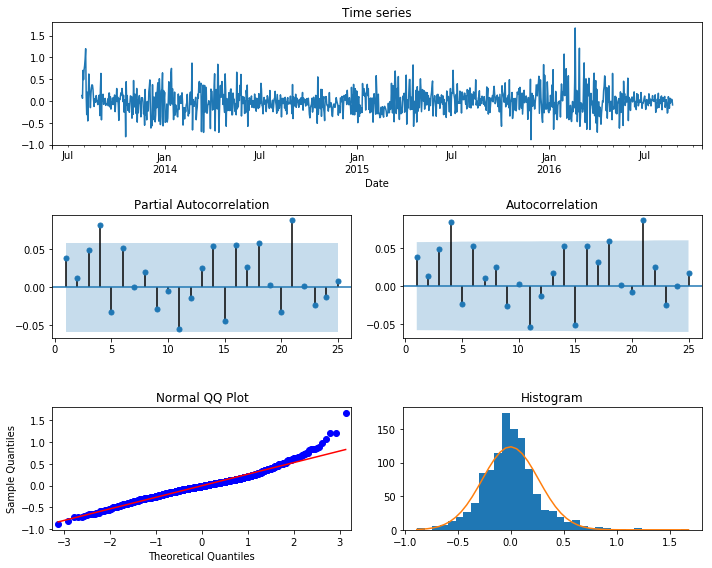

Independent Residuals (Ljung-Box Test)? True


In [23]:
ts_plot(res.resid, lags=25)

We can now forecast our data and compare it with our test values. The results are similar to our other models and accurately captures the yearly and weekly seasonality.

Test MSE: 5710.22


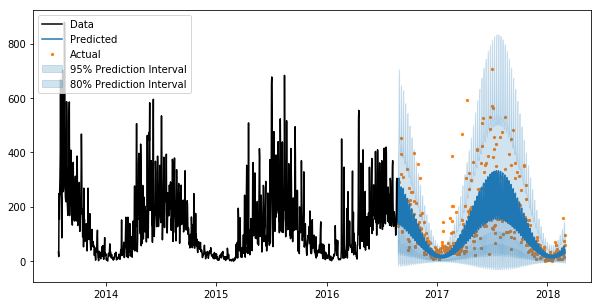

In [24]:
x = np.arange(len(train))
fourier_train = fourier_series(x)
x = np.arange(len(train), len(train)+len(test))
fourier_test = fourier_series(x)
pred = res.get_prediction(start=test.index[0], end=test.index[-1])

y_train = train
y_test = test
y_pred = untransform(pred.predicted_mean)*fourier_test
pred_ci = untransform(pred.conf_int(alpha=0.05)).multiply(fourier_test, axis=0)

test_mse = mean_squared_error(test, y_pred)
cogo_mse.loc['ARIMA'] = test_mse
print('Test MSE: {:.2f}'.format(test_mse))

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")
plt.plot(y_train, label='Data', color='black')
plt.scatter(y_test.index, y_test.values, label='Actual', color=cmap(1), s=5)
plt.plot(y_pred, label='Predicted', color=cmap(0))

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], 
                 color=cmap(0), alpha=0.2, label='95% Prediction Interval')

pred_ci = pred.conf_int(alpha=0.2).multiply(fourier_test, axis=0)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], 
                 color=cmap(0), alpha=0.2, label='80% Prediction Interval')

plt.legend(loc='upper left')
plt.show()

## 5. Neural Networks

The last forecasting method I'll use is neural networks. So far, my forecasting methods have generally involved fitting models to linear differenced equations (ETS, ARIMA) or to the lines and sinusoidal equations that are their solutions (Prophet). In practice, I often had to combine both methods. However, these methods have generally relied on linear equations. 

The benefit of neural networks comes from the Universal Approximation Equation that states that a neural network with a single hidden layer can approximate *any* continuous equation, even non-linear ones. This allows neural networks to be generalized non-linear equation solvers even when the preferred non-linear equation isn't known apriori.

But because no formuula to be inputted to be fitted to, they require many training iterations and/or large amounts of training data. They are also prone to fitting to local minimum rather than global maximum. It is for these reasons that other modelling methods are often preferred for forecasting applications.

The two most common types of neural networks used for forecasting include multilayer perceptron networks (MPN) and long short-term memory networks (LSTM). 

MPN used one or more hidden layers to transform input data into one or more outputs. They have no concept of time flow and the same network is used regardless of whether it is the first or last data set. In practice though, they can be setup to not be conceptually very different from an AR model where some combination of the last several values are combined together to predict the next data point. The benefit of MPN is that they should be able to model a larger range of equations than simply linear differenced equations.

LSTMs are able to update their network after each time slice. Models like exponential smoothing naturally have a relative (exponentially) short memory. In contrast, LSTMs decide each step whether to update their memory or not and are capable of having larger memory effects. While conceptually, LSTMS appear more suited for forecasting applications. In practice, most forecasting applications don't require long memories as we've seen from PACF and ACF plots. 

In my initial trails, LSTMs were more computationally expensive, were harder to converge, and did not yield better results so I've decided to stick with MPN.

I have several helper functions to help with this task. Notably, I have to transform my time series so that it includes a sliding window that includes the last several values and seasonally adjusted values. I also have to create a function that allows us to predict more than one step forward from the training set. The MPN only predicts the next value. To predict more than one value ahead, intermediate values must first be forecasted. This is how other forecasting packages work but needs to be manually done for neural networks because they are used for many applications beyond forecasting. However, this crucial step is commonly forgotten.

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    from keras.callbacks import Callback
    from keras import regularizers

class LossHistory(Callback):
    """Callback that tracks the loss after each training epoch."""
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        
def create_seasonal_dataset(ts, slen=[], lags=1, slags=1):
    """Maps time series into a sliding widow with seasonal components and its corresponding next value
    
    Args:
        ts (Series): Time Series
        slen (list(int)): Seasonality length
        lags (int): Number of values in each sliding window
        slags (int): Number of values in each seasonal sliding window
    Returns:
        dataX (2D array): Sliding window
        dataY (1D array): Next value to be forecasted from the sliding window
    """
    dataX = [ts.shift(x).values[-lags:] for x in range(len(ts))[::-1]]
    for s in slen:
        arr = [ts.shift(x).values[-(s*slags)-1:-s:s] for x in range(len(ts))[::-1]]
        dataX = np.concatenate([dataX, arr], axis=1)
    dataX = dataX[max(slen)*slags:-1]
    
    dataY = ts.shift(-1).values
    dataY = dataY[max(slen)*slags:-1]
    return(dataX, dataY)

def predict_datasets(dataX, n, slen=[], lags=1, slags=1):
    """Takes the neural network input data and creates predictions based on the neural network
    
    Args:
        dataX (2D array): Sliding window input to neural network used for training
        n (int): Number of future steps to predict
        slen (list(int)): Seasonality length
        lags (int): Number of values in each sliding window
        slags (int): Number of values in each seasonal sliding window
    Returns:
        dataX: Sliding window for both training and test set. Test set is based on one step ahead predictions
        dataY: Predicted values"""
    dataY = np.zeros(n)
    for i in range(n):
        old_lag = dataX[-1][1:lags]
        pred_val = model.predict(dataX[-1:]).flatten()[0]
        next_row = np.append(old_lag, pred_val)

        for j, s in enumerate(slen):
            old_seasonal_lag = dataX[-s, (lags+j*slags+1):(lags+(j+1)*slags)]
            last_seasonal_value = dataX[-s, lags-1]
            next_row = np.hstack((next_row, old_seasonal_lag, last_seasonal_value))

        next_row = next_row.reshape(1,-1)
        dataX = np.append(dataX, next_row, axis=0)
        dataY[i] = pred_val
    return(dataX, dataY)

Using TensorFlow backend.


## 5.1 $\mathrm{CO_2}$ Data with Neural Networks

So the basic procedures for forecasting with neural networks is (1) divide your time series into sliding window segments that can be inserted into the neural network, (2) fit the neural network, and (3) iteratively predict the next value for as far out as necessary. 

The neural network needs to take in as many inputs as our sliding window contains and in our case it is outputting the next predicted value. There is no hard and fast rule for the number or size of the hidden layers in between. Unlike other modelling methods, neural networks typically are expected to have too many fitting parameters and instead use regularization to prevent overfitting. Regularization penalizes solutions where the fitting parameters are overly large. 

There are a number of different activation functions for each node. Rectified linear units (relu) are often used because they satisfy a version of the universal approximation theorem (despite being non-bounded) and are relatively quick to train. Relu's return 0 for negative values and otherwise return the inputted value.

During the training, the neural network is updated after looking through a number of data points called a batch. Each time the training dataset is used to train the data is called an epoch. 

So there are many variables that can be tweaked when creating a neural network. You can change the size of the network, the strength of the regularization, the number of training batches or epochs, the amount of input (or even output) data, or even the activation functions. I've tried some variations with those parameters but I have not been comprehensive and have found the following values to generally work for my data.

Below I plot the loss function after each training epoch. Then the trained neural network is used to predict values which are compared with the test set.

Train Score: 5.25 MSE (2.29 RMSE)


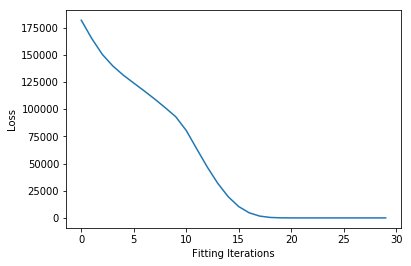

Test Score: 91.58 MSE (9.57 RMSE)


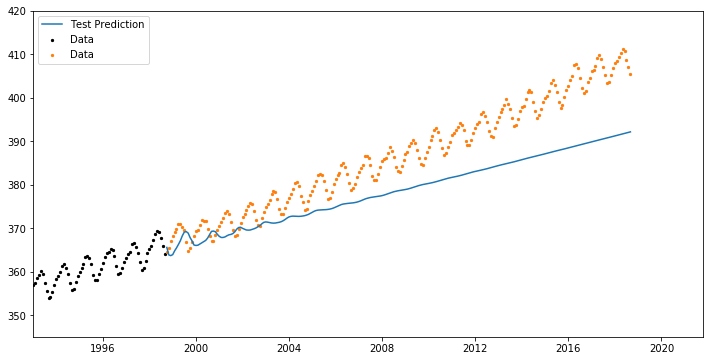

In [26]:
ts = co2
train = co2_train
test = co2_test 

slen = [12]
lags = 2
slags = 2
dim = len(slen)*slags + lags

trainX, trainY = create_seasonal_dataset(train, slen, lags, slags)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.3)))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = LossHistory()
model.fit(trainX, trainY, epochs=30, batch_size=40, verbose=0, callbacks=[history])

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))

# Plot loss curve
plt.plot(history.losses)
plt.xlabel('Fitting Iterations')
plt.ylabel('Loss')
plt.show()

# Testing Score
_, testPredict = predict_datasets(trainX, len(test), slen, lags, slags)
testScore = mean_squared_error(test.values, testPredict)
co2_mse.loc['Neural Networks'] = testScore
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

# shift test predictions for plotting
testPredictPlot = pd.Series(np.empty_like(ts), index=ts.index)
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(ts)] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(12,6))
cmap = plt.get_cmap("tab10")
plt.scatter(train.index, train.values, color='black', label='Data', s=5)
plt.scatter(test.index, test.values, color=cmap(1), label='Data', s=5)
plt.plot(testPredictPlot, color=cmap(0), label='Test Prediction')
plt.xlim(xmin=pd.Timestamp('1993'))
plt.ylim([345, 420])
plt.legend()
plt.show()

I find that the results I get vary a lot and appear entirely dependent on the starting inititalization values. The model saturates within just a few training iterations but these are very much local minima. None of the results appear to fit very well and often take the form of either exponentially growing or damped sinusoidal functions. Neither of which are appropriate for this dataset.

Part of the trouble is that the neural network is only fitting to the forecasted next value yet for testing I'm trying to predict roughly the next 200 values. I tried fitting the neural network not to just the next output but the next several outputs, but I found that my results were actually worse. I commonly only the naive solution (forecasting the last available value). 

What's also troubling is the type of outputs I'm getting. Exponentially growing or damped sinusoidal functions are solutions to linear differnetial equations. The power of neural networks is that they can model non-linear functions. For those solutions, I would be better off trying to model it with a AR model and would probably converge to a better fit.

Altogether, I'm not finding neural networks to be worth it. There's other things I could try (longer training periods, more nodes, transforming the data first, increasing length of output), but by and large they don't seem reliable and yield far worse results than any of my other models.

## 5.2 COGO Data with Neural Networks

With the COGO data, the neural networks work in much the same way. The only difference is that I include seasonal lag for both seasonalities. While computationally this isn't a problem, it does significantly decrease the training data set because I can't use the first year of data of training data.

The results are similarly bad as with the $\mathrm{CO_2}$ data. The best fits modeled the data with a damped harmonic oscillator even when the data is obviously not damped.

Train Score: 7516.82 MSE (86.70 RMSE)


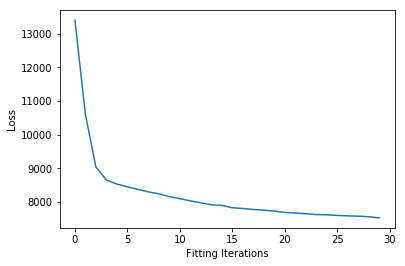

Test Score: 17487.15 MSE (132.24 RMSE)


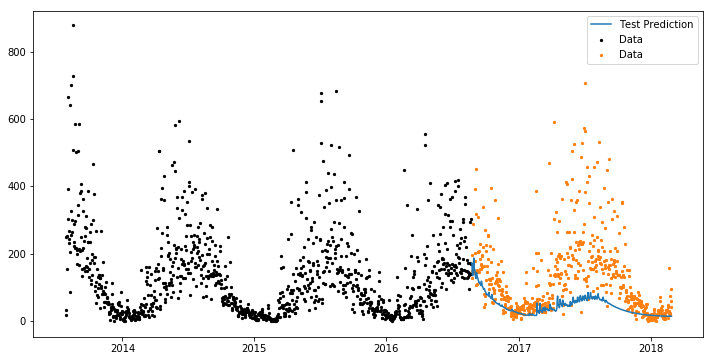

In [27]:
ts = cogo_daily
train = cogo_daily_train
test = cogo_daily_test 

slen = [365, 7]
lags = 3
slags = 1
dim = len(slen)*slags + lags

trainX, trainY = create_seasonal_dataset(train, slen, lags, slags)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(6, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = LossHistory()
model.fit(trainX, trainY, epochs=30, batch_size=40, verbose=0, callbacks=[history])

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))

# Plot loss curve
plt.plot(history.losses)
plt.xlabel('Fitting Iterations')
plt.ylabel('Loss')
plt.show()

# Testing Score
_, testPredict = predict_datasets(trainX, len(test), slen, lags, slags)
testScore = mean_squared_error(test.values, testPredict)
cogo_mse.loc['Neural Networks'] = testScore
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

# shift test predictions for plotting
testPredictPlot = pd.Series(np.empty_like(ts), index=ts.index)
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(ts)] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(12,6))
cmap = plt.get_cmap("tab10")
plt.scatter(train.index, train.values, color='black', label='Data', s=5)
plt.scatter(test.index, test.values, color=cmap(1), label='Data', s=5)
plt.plot(testPredictPlot, color=cmap(0), label='Test Prediction')
plt.legend()
plt.show()

# 6. Conclusion

## 6.1 $\mathrm{CO_2}$ Conclusion

Looking at the results of the $\mathrm{CO_2}$ data, we see that Prophet managed to do the best forecast, ARIMA and Exponential Smoothing models weren't significantly different, and the neural networks were the least effective. However, Prophet determined the slope from the final 10% of the training set. There's nothing about that method that necessarily made it any better. On the contrary, if it used the final 20% of the training set to determine the slope as was default, it actually would have fit the testing data significantly worse than the ARIMA and exponential smoothing models with a mean squared error of 54.5.

In [28]:
co2_mse.sort_values(by='Test MSE')

,Test MSE
Prophet,7.137680
ARIMA,11.690737
Exponential Smoothing,14.919265
Neural Networks,91.580017


While the sinusoidal periodicity was easily modelled in this dataset, the real difficulty was whether the model was able to determine the slope appropriately. Because the testing series was 20 years long, even small deviations in the slope became significant differences in the forecast.

The plot below shows the fit-removed training and test sets. By chance, there was a significanct deviation in the dataset that started right after the training set ended. This slight change in the slope is what caused all the models to be slightly off in the slope.

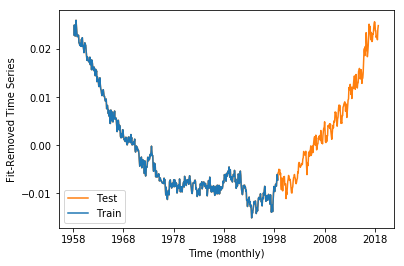

In [29]:
train = co2_train
fourier_series = fit_fourier_order(train, 2, 12)
fourier_train = fourier_series(np.arange(len(train)))
transformed_train = train / fourier_train

ts = co2
fourier_ts = fourier_series(np.arange(len(ts)))
transformed_ts = ts / fourier_ts

cmap = plt.get_cmap("tab10")
x = np.arange(len(transformed_ts))
fit = np.polyfit(x, transformed_ts, 1)
plt.plot(transformed_ts - np.poly1d(fit)(x), color=cmap(1), label='Test')

x = np.arange(len(transformed_train))
plt.plot(transformed_train - np.poly1d(fit)(x), color=cmap(0), label='Train')
plt.xlabel('Time (monthly)')
plt.ylabel('Fit-Removed Time Series')
plt.legend()
plt.show()

## 6.1 COGO Conclusion

Looking at the results of the COGO data data, Prophet did significantly worse than the ARIMA and exponential smoothing models. Once again, the ARIMA and exponential smoothing models performed similarly but with ARIMA doing slightly better. And the neural networks did significantly worse than any of the other models.

In [30]:
cogo_mse.sort_values(by='Test MSE')

,Test MSE
ARIMA,5710.221380
Prophet,5898.780755
Exponential Smoothing,6198.834886
Neural Networks,17487.153459


With the COGO data, I feel like the main thing missing is other variables that would affect ridership. The model doesn't take into account holidays or the weather. 

For every model except neural networks, a partial Fourier series was used to model the yearly trend. Below, I've plotted what that data looks like. While the data appears fairly regular, there is a giant unexplained peak on February 20th, 2016. That day was an excpetionally warm Saturday (high in the 60s) after a cold week (high in the mid-30s). Bike ridership was obviously influenced by weather on that day. 

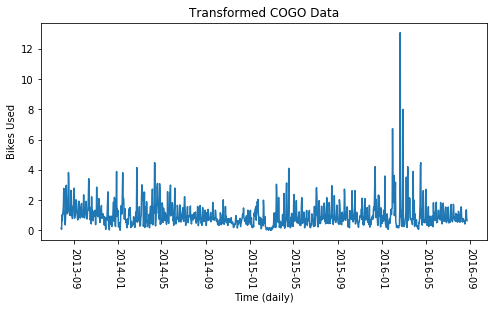

In [31]:
train = cogo_daily_train
fourier_series = fit_fourier_order(train, 2, 365)
fourier_train = fourier_series(np.arange(len(train)))
transformed_train = train / fourier_train

plt.figure(figsize=(8,4))
plt.plot(transformed_train)
plt.xticks(rotation=-90)
plt.xlabel('Time (daily)')
plt.ylabel('Bikes Used')
plt.title('Transformed COGO Data')
plt.show()

This just emphasizes that these forecasting methods are relatively naive. They don't contain any Physics-like models of the underlying phenomenon, but rather predict future values from previous values. There are other methods not looked at here such as Kalman filters that combine formulaic modeling with modelling based on prior results.

Many of the models looked at here also have the ability to include spikes from holidays or exogenous variables. This would be a way to potentially improve these models further, but there is a limit to how well you expect to be able to model human behavior as well and we may be nearing that limit. With the ARIMA model, we saw that the residuals looked like white noise indicating that the model provided a good fit to the data.